# Time Series Traffic Analysis

In [62]:
%matplotlib notebook

import os
import shutil
import urllib3

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [63]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"
PATH = "metro_interstate.csv.gz"


def fetch_data(url=URL, path=PATH):
    http = urllib3.PoolManager()
    with open(path, 'wb') as f:
        r = http.request('GET', url, preload_content=False)
        shutil.copyfileobj(r, f)
    

# Only need to run once!
fetch_data()

In [64]:
data = pd.read_csv(
    "metro_interstate.csv.gz",
    index_col="date_time",
    parse_dates=True
)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


<IPython.core.display.Javascript object>


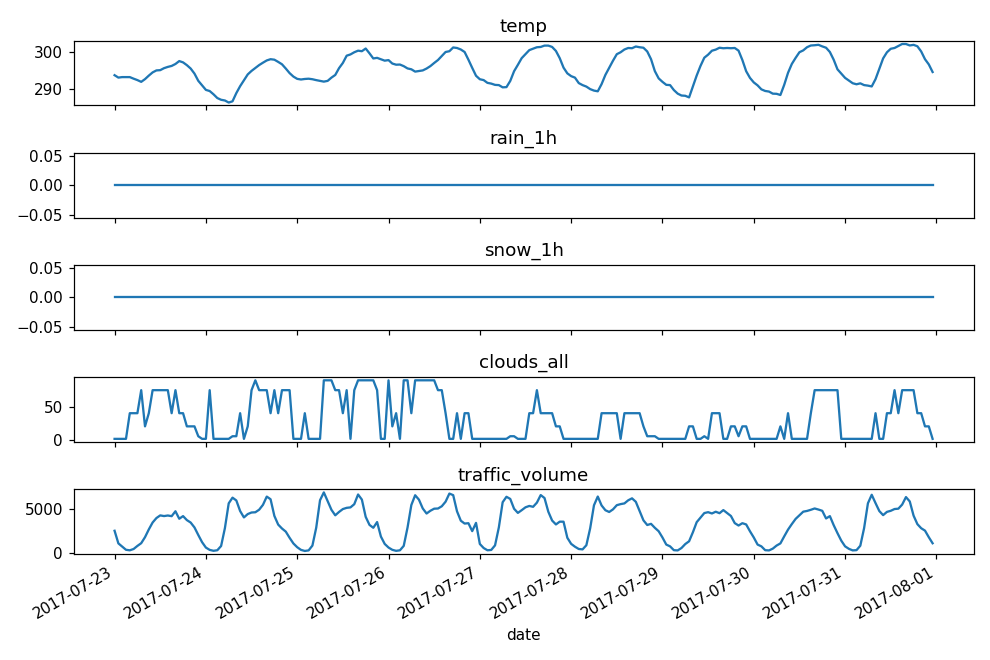

In [65]:
def plot_numeric_features(df=data, cols=["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]):
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, figsize=(9,6))
    
    for col, ax in zip(cols, axes):
        df[col].plot(ax=ax)
        ax.set_title(col)
        
        if ax == axes[-1]:
            ax.set_xlabel("date")
    
    fig.tight_layout()
    return ax


# Plot features in date range
_ = plot_numeric_features(data.loc["2017-07-23":"2017-07-31"])

<IPython.core.display.Javascript object>


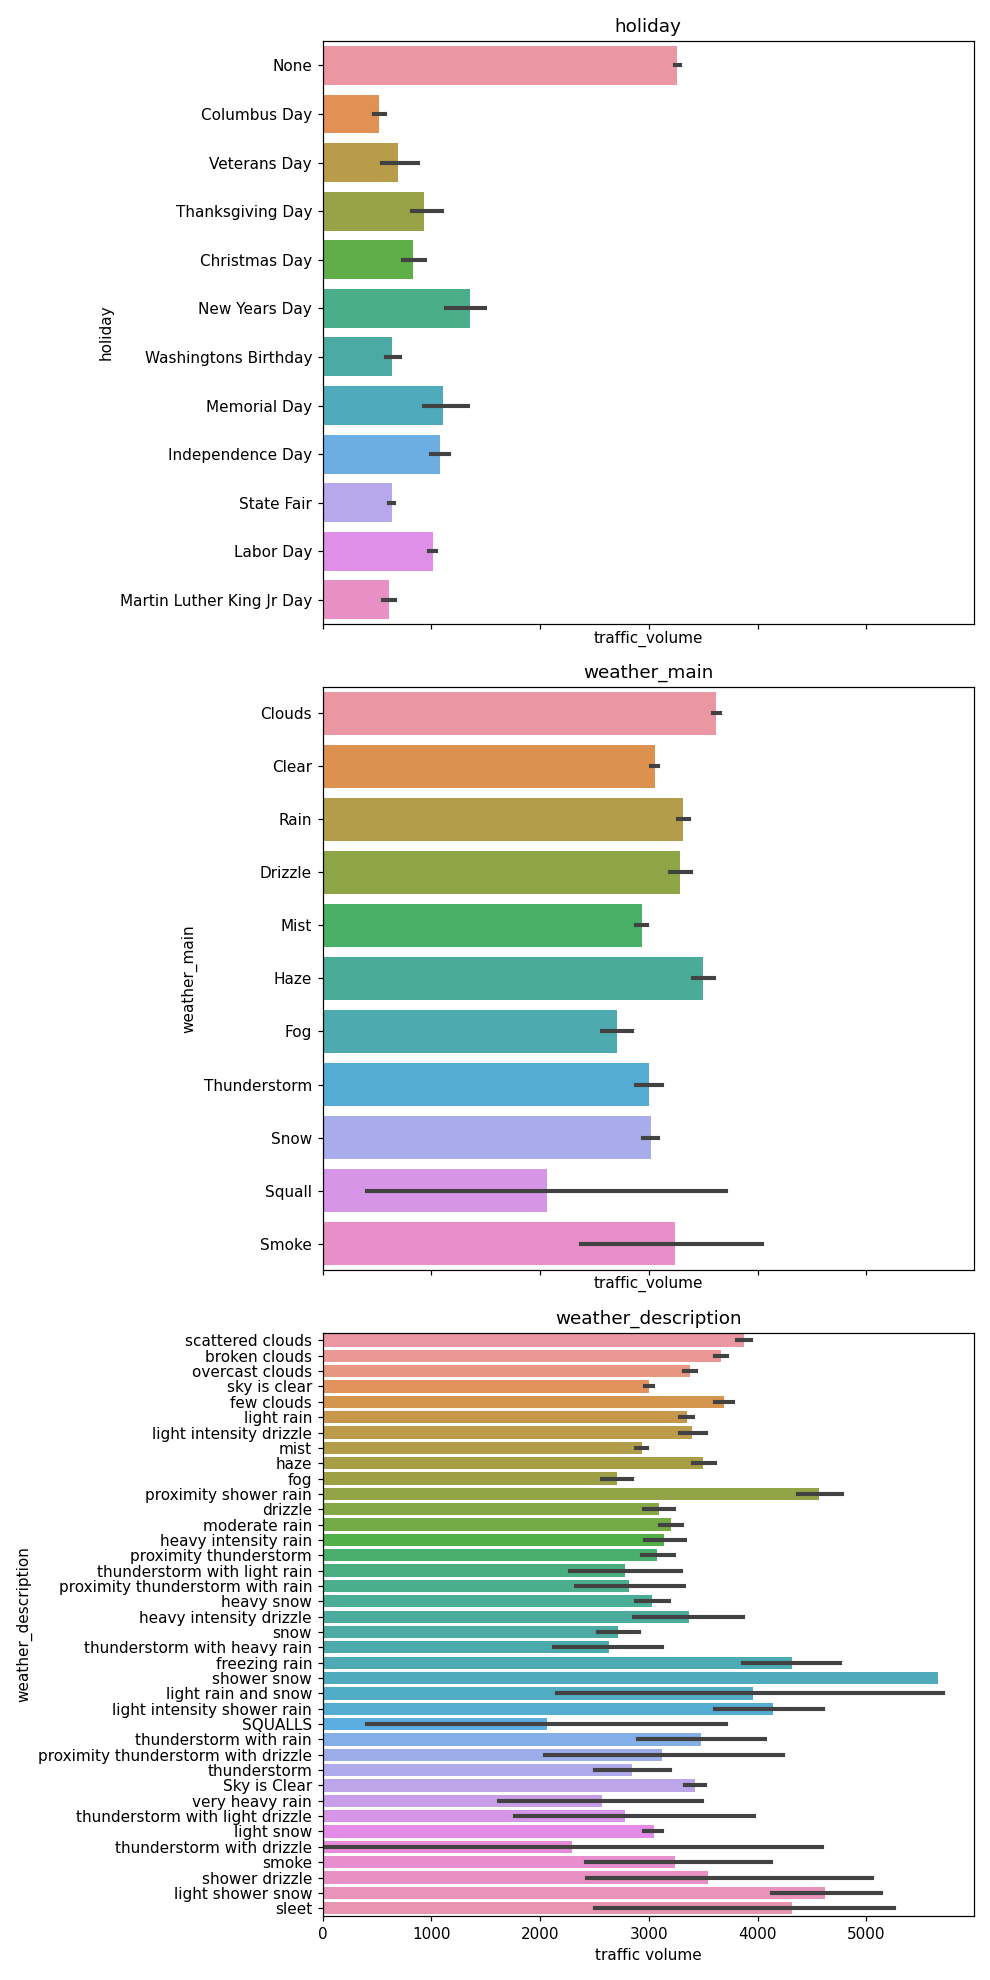

In [68]:
def plot_categorical_features(df=data, cols=['holiday', 'weather_main', 'weather_description']):
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, figsize=(9,18))
    
    for col, ax in zip(cols, axes):
        sns.barplot(x='traffic_volume', y=col, data=df, ax=ax)
        ax.set_title(col)
        
        if ax == axes[-1]:
            ax.set_xlabel('traffic volume')
    
    
    fig.tight_layout()
    return ax


_ = plot_categorical_features(data)

## Time Based Transformers

In this section we will extract the following features:

- cyclic encoding of hour of day
- cyclic encoding of day of year
- binarize if the day is a holiday or not
- one hot encode the weather description 

In [73]:
from sklearn.model_selection import train_test_split as tts


TARGET = "traffic_volume"
COLS = ["date_time", "holiday", "weather_main", "temp", "rain_1h", "snow_1h", "clouds_all"]


def make_sklearn_data(df=data, splits=True, train_size=0.8, target=TARGET, cols=COLS):
    # Add the datetime column back to the main dataframe
    df = df.reset_index()
    X, y = df[cols], df[target]
    
    if splits:
        return tts(X, y, train_size=train_size)
    return X, y

<IPython.core.display.Javascript object>


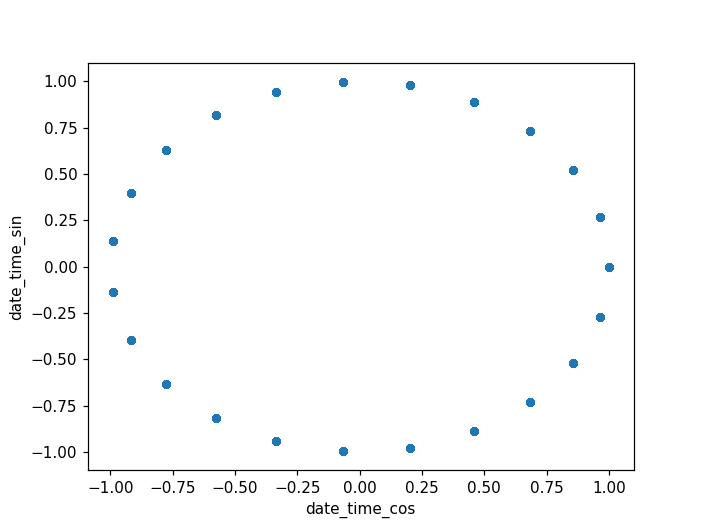

In [135]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="hour"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "hour":
            return x.dt.hour
        elif self.date_extract == "year":
            return x.dt.isocalendar().day
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(data.reset_index()["date_time"])
ce.plot(x="date_time_cos", y="date_time_sin", kind="scatter")

In [136]:
class HolidayBins(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray([[
            0 if xi == 'None' else 1 for xi in X
        ]]).T

In [137]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder


extraction = [
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('hour_of_day', CyclicEncoder(date_extract="hour")),
            ('day_of_year', CyclicEncoder(date_extract="year")),
        ]), 'date_time'),
        ('holiday_binerize', HolidayBins(), 'holiday'),
        ('weather', OneHotEncoder(), ['weather_main']),
    ], remainder="passthrough")),    
]


X, y = make_sklearn_data(splits=False)
Pipeline(extraction).fit_transform(X).shape

(48204, 20)

In [138]:
from sklearn.ensemble import RandomForestRegressor 


X_train, X_test, y_train, y_test = make_sklearn_data()

extraction.append(("clf", RandomForestRegressor()))
model = Pipeline(extraction)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9363990940583449